In [1]:
from __future__ import division, print_function
from concurrent.futures import ProcessPoolExecutor, wait
from matplotlib import pyplot as plt
from scipy import optimize as sco
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys
import os

In [2]:
data_t0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuTau_1_1_1.npy',mmap_mode='r')
data_m0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuMu_1_1_1.npy',mmap_mode='r')
data_e0 = np.load('/fastio2/dasha/double_pulse/data_11vars_NuE_1_1_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_Corsika_11057_11058_10670_trial.npy',mmap_mode='r')

In [3]:
maskl_t = data_t0['logan_veto']['SPE_rlogl']-data_t0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_m = data_m0['logan_veto']['SPE_rlogl']-data_m0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_e = data_e0['logan_veto']['SPE_rlogl']-data_e0['logan_veto']['Cascade_rlogl'] >-0.1
maskl_c = data_c0['logan_veto']['SPE_rlogl']-data_c0['logan_veto']['Cascade_rlogl'] >-0.1
masks_t = (data_t0['preds']['n1'] >= 0.99) & (data_t0['preds']['n4'] >= 0.8)
masks_m = (data_m0['preds']['n1'] >= 0.99) & (data_m0['preds']['n4'] >= 0.8)
masks_e = (data_e0['preds']['n1'] >= 0.99) & (data_e0['preds']['n4'] >= 0.8)
masks_c = (data_c0['preds']['n1'] >= 0.99) & (data_c0['preds']['n4'] >= 0.8)
mask_t = maskl_t & masks_t
mask_m = maskl_m & masks_m
mask_e = maskl_e & masks_e
mask_c = maskl_c & masks_c
data_t = data_t0[mask_t]
data_m = data_m0[mask_m]
data_e = data_e0[mask_e]
data_c = data_c0[mask_c]
print(data_t.shape,data_m.shape,data_e.shape,data_c.shape)

(990,) (51,) (12,) (0,)


In [5]:
sig = sum(data_t['weight_val'])
bkg = sum(data_m['weight_val'])+sum(data_e['weight_val'])+sum(data_c['weight_val'])
print(sig,bkg)

0.8615237111498573 0.050096751325327205


In [13]:
class BinnedPoissonLikelihood():
    '''
    Likelihood: Binned Poisson
    Model: P_B(x) + lmd_S * P_S(x)
    '''
    def __init__(self, sig, bkg, random_state):
        self.sig = sig
        self.bkg = bkg
        self.random_state = random_state

    def log_likelihood(self, lmd, data):
        expected = self.bkg + lmd * self.sig
        result =  data * np.log(expected) - expected
        return -result

    def test_statistic(self, lmd, data):
        expected = self.bkg + lmd * self.sig
        null = self.bkg
        result = data * (np.log(expected) - np.log(null)) - expected + null
        return -result
    
    def test_statistic_best(self, lmd, true_lmd, data):
        expected = self.bkg + lmd * self.sig
        null = self.bkg + true_lmd * self.sig
        result = data * (np.log(expected) - np.log(null)) - expected + null
        return -result
    
    def fit_lmd(self, data):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic,
            x0=pars,
            bounds=par_bounds,
            args=(data,),
            approx_grad=True
        )

        # set up mindict to enter while, exit if fit looks nice
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic,
                x0=pars,
                bounds=par_bounds,
                args=(data,),
                approx_grad=True
            )
            i += 1

        return fmin, xmin
    
    def fit_lmd_best(self, true_lmd, data):
        pars = [0.5]
        par_bounds = [(0, 100)]

        xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
            func=self.test_statistic_best,
            x0=pars,
            bounds=par_bounds,
            args=(true_lmd, data,),
            approx_grad=True
        )
        i = 1
        while min_dict["warnflag"] == 2 or b'FACTR' in min_dict["task"]:
            if i > 100:
                print("Did not manage good fit")
                print('results are {}, {}'.format(fmin, xmin))
                return fmin, xmin

            pars[0] = self.random_state.uniform(0., 1.)

            # no stop due to gradient
            xmin, fmin, min_dict = sco.fmin_l_bfgs_b(
                func=self.test_statistic_best,
                x0=pars,
                bounds=par_bounds,
                args=(true_lmd, data,),
                approx_grad=True
            )
            i += 1

        return fmin, xmin

In [18]:
class SignalInjector(object):
    def __init__(self, sig, bkg, random_state, sig_exp=None, bkg_exp=None):
        if sig_exp is not None:
            self.sig_exp = sig_exp
        else:
            self.sig = sig
            
        if bkg_exp is not None:
            self.bkg_exp = bkg_exp
        else:
            self.bkg_exp = bkg

        self.sig = sig
        self.bkg = bkg
        self.random_state = random_state

    def calc_n_trials(self, n_trials):
        n_sig_trials = self.random_state.poisson(lam=self.sig_exp, size=n_trials)
        n_bkg_trials = self.random_state.poisson(lam=self.bkg_exp, size=n_trials)
        return n_sig_trials, n_bkg_trials

    def do_trials(self, n_trials, llh):
        self.sig_trials, self.bkg_trials = self.calc_n_trials(n_trials)
        
        ts_vals = []
        lmds = []
        true_lmd = self.sig_exp / float(np.sum(self.sig))
        
        for i in range(n_trials):
            samples = (self.sig_trials[i] + self.bkg_trials[i])
            ts, lmd = llh.fit_lmd_best(true_lmd, samples)
            ts_vals.append(-ts)
            lmds.extend(lmd)
        return ts_vals, lmds

In [19]:
def scan_neyman_row(sig_inj, n_samples, likelihood, mu):
    sig_ts,_ = sig_inj.do_trials(
        n_samples, likelihood)
    sig_ts = np.array(sig_ts)
    sig_ts[sig_ts < 0] = 0
    return sig_ts, mu

def scan_neyman_plane(sig, bkg, bkg_exp, mu_bins, ts_bins, n_samples_per_mu, n_jobs=2, save=False, out_path=None):
    def save_stuff(out_path, hist, mu):
        if out_path is not None:
            out_path1 = os.path.join(out_path, 'ts_mu_{}.npz'.format(mu_i))
            np.savez(out_path1, hist)

    if not save:
        hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
        
    random_state = np.random.RandomState(42)
    likelihood = BinnedPoissonLikelihood(sig, bkg, random_state=random_state)

    if n_jobs > 1:
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            futures = []
            for i, mu_i in enumerate(mu_bins):
                injector_rs = np.random.RandomState(i)
                sig_inj = SignalInjector(sig, bkg, injector_rs, sig_exp=mu_i, bkg_exp=bkg_exp)
                futures.append(
                    executor.submit(
                        scan_neyman_row,
                        sig_inj=sig_inj,
                        n_samples=n_samples_per_mu,
                        likelihood=likelihood,
                        mu=mu_i))
            results = wait(futures)
            
        for i, future_i in enumerate(results.done):
            try:
                sig_ts, mu_i = future_i.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (future_i, exc))
          
            hist, ts_e = np.histogram(sig_ts, bins=ts_bins)
            hist = hist / float(np.sum(hist))
            if not save:
                hists[idx] = hist
            else:
                save_stuff(out_path, sig_ts, mu_i)
                
    if not save:
        return hists, ts_e
    else:
        return 0, 0

In [22]:
n_jobs=20
n_samples=1000
mu_bins = np.linspace(0, 50, 801)
ts_bins = np.linspace(0, 20, 201)
ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
out_path ="/home/dup193/work/double_pulse/onebin_test/ts_dist/"

hists, ts_e = scan_neyman_plane(sig, bkg, bkg, mu_bins, ts_bins, n_samples, n_jobs=n_jobs, save=True, out_path=out_path)


In [26]:
from glob import glob
import re
name_out = "/home/dup193/work/double_pulse/onebin_test/ts_dist/"
mat = []
hists = np.zeros((len(mu_bins), len(ts_bins) - 1))
for file_name in glob(name_out+'*'):
    sp = re.split('_|\.|/',file_name)
    mu = float(sp[-3]+"."+sp[-2])
    i = np.where(mu_bins==mu)
    x = np.load(file_name, mmap_mode="r")['arr_0']
    #print(x)
    hist, ts_e = np.histogram(x, bins=ts_bins)
    hist = hist / float(np.sum(hist))
    hists[i] = hist

In [27]:
print(hists)

[[0.944 0.    0.    ... 0.    0.    0.   ]
 [0.    0.892 0.    ... 0.    0.    0.   ]
 [0.    0.84  0.    ... 0.    0.    0.   ]
 ...
 [0.268 0.099 0.128 ... 0.    0.    0.   ]
 [0.288 0.098 0.127 ... 0.    0.    0.   ]
 [0.245 0.107 0.15  ... 0.    0.    0.   ]]


/home/dup193/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


Text(0, 0.5, 'Mean signal expectation $\\mu_t$')

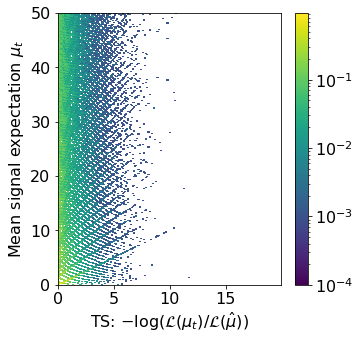

In [28]:
from matplotlib.colors import LogNorm
vmin = np.min([np.min(hist) for hist in hists])
vmax = np.max([np.max(hist) for hist in hists])
fig = plt.figure(figsize=(5, 5),facecolor ='w')
plt.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='both', style='sci', scilimits=(-5,5))
ax = fig.add_subplot()
for i in range(len(mu_bins) - 1):
    Xe, Ye = np.meshgrid(ts_bins, [mu_bins[i], mu_bins[i+1]])
    im = ax.pcolormesh(Xe, Ye, np.atleast_2d(hists[i]), vmin=vmin+1e-4, vmax=vmax, norm=LogNorm())
plt.colorbar(im)
ax.set_xlabel('TS: $-\log(\mathcal{L}(\mu_t) / \mathcal{L}(\hat{\mu}))$')
ax.set_ylabel(r'Mean signal expectation $\mu_t$')